## Analytical and simulated capped CPW

Analysis of Dunsworth (2018) expression for $p_{ox}$, CR McRae (2017) expression for capped vs uncapped Q, and my own models for loss in a CPW resonator when an oxide is present. Comparison to HFSS simulations to find $p_{ox}$, $p_{ms}$, and $p_{ma}$

In [30]:
from __future__ import division
from scipy.special import ellipk as K
import numpy as np
from numpy import sinh, tanh
import matplotlib.pyplot as plt
import plot_settings # my personal default settings for matplotlib

_Define elliptic function arguments as found in Simons, Section 2_

In [110]:
def get_k0(S,W, h):
    # conf parameter for isolated CPW, infinite substrate
    # dummy h left in for get_kprime input uniformity
    return S/(S+2*W)

def get_k12(S,W,h):
    # conf parameter for dielectrics below (1) or above(2) CPW
#     print(S, W, h)
#     print("top", sinh(np.pi*S/(4*h)))
#     print("bot", sinh(np.pi*(S+2*W)/(4*h)))
#     print(np.pi*(S+2*W)/(4*h))


    A = np.pi*S/(4*h)
    B = np.pi*(S+2*W)/(4*h)
    if A > 710 or B > 710:
        print("WARNNG: overflow in sinh at get_k12")
        return 0
    else:
        return sinh(A)/sinh(B)

def get_k34(S,W,h):
    # conf parameter for ground plane below (3) or above (4) CPW
    return tanh(np.pi*S/(4*h))/tanh(np.pi*(S+2*W)/(4*h))

def get_kprime(S,W,h,kfunc):
    # passed a k_i parameter, return the respective kprime
    return np.sqrt(1-kfunc(S,W,h)**2)

def G(k, kprime):
    return K(k)/K(kprime)

def get_qi0(S, W, hi):
    # return either q10 or q20 - see N3-132
 
    k0 = get_k0(S, W, None)
    k0prime = get_kprime(S, W, None, get_k0)
 
    ki = get_k12(S, W, hi)
    kiprime = get_kprime(S, W, hi, get_k12)
    return G(ki, kiprime)/(2*G(k0, k0prime))

def get_q3(S, W, hi, h4):
    # return either q3 or q2 - see N3-132
    
    k0 = get_k0(S, W, None)
    k0prime = get_kprime(S, W, None, get_k0)
    
    ki = get_k12(S, W, hi)
    kiprime = get_kprime(S, W, hi, get_k12)
    
    k4 = get_k34(S, W, h4)
    k4prime = get_kprime(S, W, h4, get_k34)
    
    # Equation 2.40 from Simons
    return G(ki, kiprime)/(G(k0, k0prime) + G(k4, k4prime))
    



_Define functions for analytical quality factor ratios_

In [111]:
def Q_Qcap(S, W, h1, h4, epsr_1):
    """
    Compute the ratio of uncapped CPW to capped CPW - see
    N3-121:132 for derivations etc.
    args:
        S - central conductor width for CPW
        W - CPW gap to ground
        h1 - substrate thickness 
        h4 - cap height
        epsr_1 - substrate relative permittivity
    """
    # ratio of qualities for uncapped/capped resonator quality 
    # h4 is the height of the cap, h1 is the subs
    # CR McRae (2017)
    
    q3 = get_q3(S, W, h1, h4)
    top = (1+epsr_1)*q3
    bot = (epsr_1 - 1)*q3 +1
    return top/bot
    
def Q_Qcap_ox(S, W, h1, h2, h4, epsr_1, epsr_2):
    """
    Compute the ratio of uncapped+oxide CPW to capped+oxide CPE - see
    N3-121:132 for derivations etc.
    args:
        S - central conductor width for CPW
        W - CPW gap to ground
        h1 - substrate thickness 
        h2 - surface "oxide" thickness
        h4 - cap height
        epsr_1 - substrate relative permittivity
        epsr_2 - surface "oxide" relative permittivity
    """
    q1 = get_q3(S, W, h1, h4)
    q2 = get_q3(S, W, h2, h4) # overloading q3 func
    q10 = get_qi0(S, W, h1)
    q20 = get_qi0(S, W, h2)
    
    top = 1 + (epsr_1 -1)*q10 + (epsr_2 -1)*q20 # ~ Q for ox, no cap
    bot = 1 + (epsr_1 -1)*q1 + (epsr_2 -1)*q2 # ~ Q for ox, with cap
    
    
    return top/bot



### Sample analysis 

Plot ratios of Qcpw/Qcap and Q_cpw(ox)/Qcap(ox)

WARNNG: overflow in sinh at get_k12
WARNNG: overflow in sinh at get_k12
WARNNG: overflow in sinh at get_k12
WARNNG: overflow in sinh at get_k12


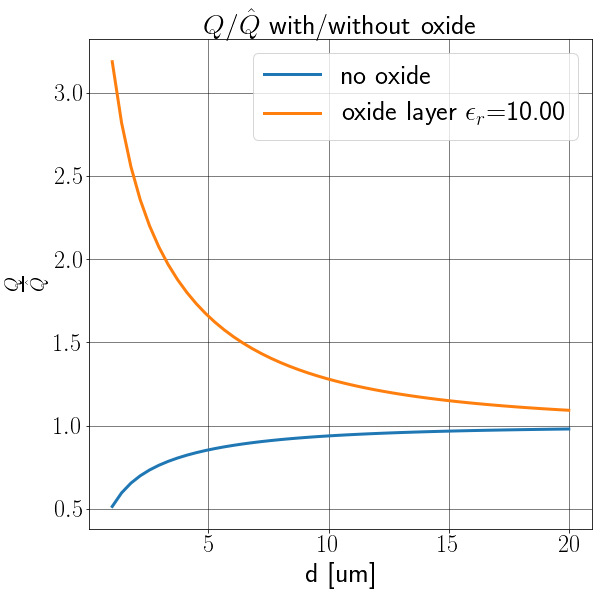

In [113]:
# CPW parameters, all in [um]
H1 = 500 # standard substrate
H2 = .01 # 10 nm oxide
H4 = 20 # base height for cap
S = 15 # CPW inner conductor width
W = 9 # CPW conductor gap
EPSR_1 = 10 # Silicon 
EPSR_2 = 10 # standard oxide approx

# Solve for quality ratios (with/without oxide) against cap height
H4_arr = np.linspace(1,20,50)
#Q_Qcap_arr = Q_Qcap(S, W, H1, H4_arr, EPSR_1)
Q_Qcap_ox_arr = Q_Qcap_ox(S, W, H1, H2, H4_arr, EPSR_1, EPSR_2)

# Plotting these ratios together
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.plot(H4_arr, Q_Qcap_arr)
ax.plot(H4_arr, Q_Qcap_ox_arr)


ax.set_title(r'$Q/\hat{Q}$ with/without oxide')
ax.set_xlabel("d [um]")
ax.set_ylabel(r'$\frac{Q}{\hat{Q}}$')
plt.grid()
ax.legend(["no oxide", "oxide layer $\epsilon_r$=%4.2f" % EPSR_2])
plt.show()

some analysis of limits of $k_i$

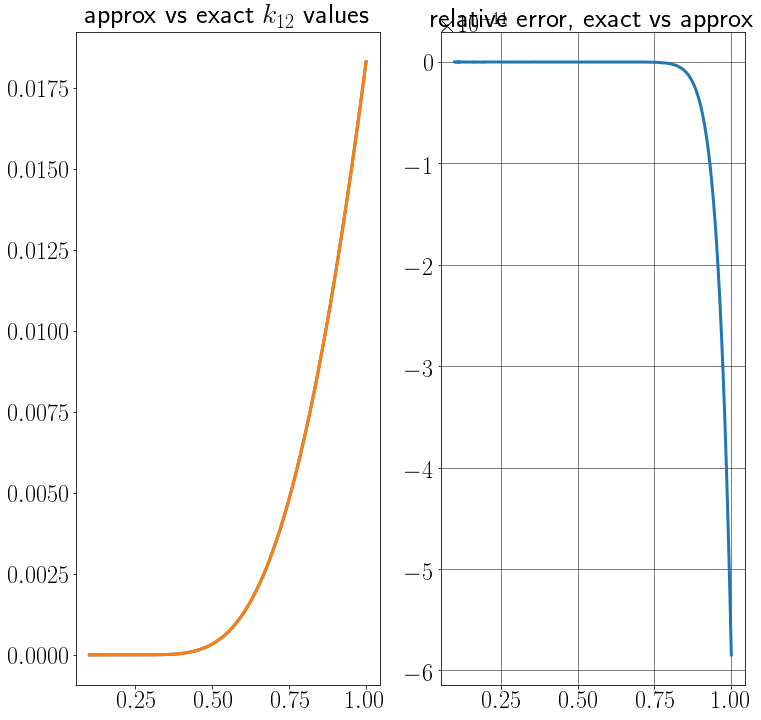

In [125]:
xvals = np.linspace(.1,1,1000) # oxide thicknesses, um
exact = lambda S, W, t: np.sinh(np.pi*S/(4*t))/np.sinh((np.pi*S+2*W)/(4*t))
approx = lambda S, W, t: np.exp(-2*W/(4*t))

sinh_vals = exact(15, 8, xvals)
exp_vals = approx(15, 8, xvals)
diff = (sinh_vals - exp_vals )/sinh_vals



fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(121)
ax1.plot(xvals, sinh_vals )
ax1.plot(xvals, exp_vals)
ax1.set_title(r'approx vs exact $k_{12}$ values')

ax2 = fig.add_subplot(122)
ax2.plot(xvals, diff)
ax2.set_title(r'relative error, exact vs approx')
plt.grid()
plt.show()